# Demo

In [1]:
# Add code to sys.path
import sys
sys.path.append('../src')

# Display
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## 1. Load default model

In [2]:
# Select GPU ID
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import torch
from models import load_model_from_path
from utils import coerce_to_path_and_check_exist
from utils.path import MODELS_PATH
from utils.constant import MODEL_FILE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TAG = 'default'
model_path = coerce_to_path_and_check_exist(MODELS_PATH / TAG / MODEL_FILE)
model, (img_size, restricted_labels, normalize) = load_model_from_path(model_path, device=device, attributes_to_return=['train_resolution', 'restricted_labels', 'normalize'])
_ = model.eval()

[2020-07-08 16:55:10] Model res_unet18 initialisated with norm_layer=InstanceNorm2d({'momentum': 0.1, 'affine': True, 'track_running_stats': False}) and kwargs {'encoder_name': 'resnet18', 'use_ctx_module': False, 'ctx_identity_init': False, 'scale_depth': 5, 'n_init_channels': 16, 'reduced_layers': False, 'no_maxpool': False, 'conv_as_maxpool': True, 'use_deconv': True, 'use_upcatconv': False, 'use_conv1x1': False, 'pretrained_encoder': False}


## 2. Load and pre-process an input image 

In [4]:
from PIL import Image
import numpy as np
from utils.image import resize

img = Image.open('img.jpg')

# Resize 
img = resize(img, img_size)
print(f'image size is: {img.size}')

# Normalize and convert to Tensor
inp = np.array(img, dtype=np.float32) / 255
if normalize:
    inp = ((inp - inp.mean(axis=(0, 1))) / (inp.std(axis=(0, 1)) + 10**-7))
inp = torch.from_numpy(inp.transpose(2, 0, 1)).float().to(device)

image size is: (830, 1280)


## 3. Predict segmentation maps and show results

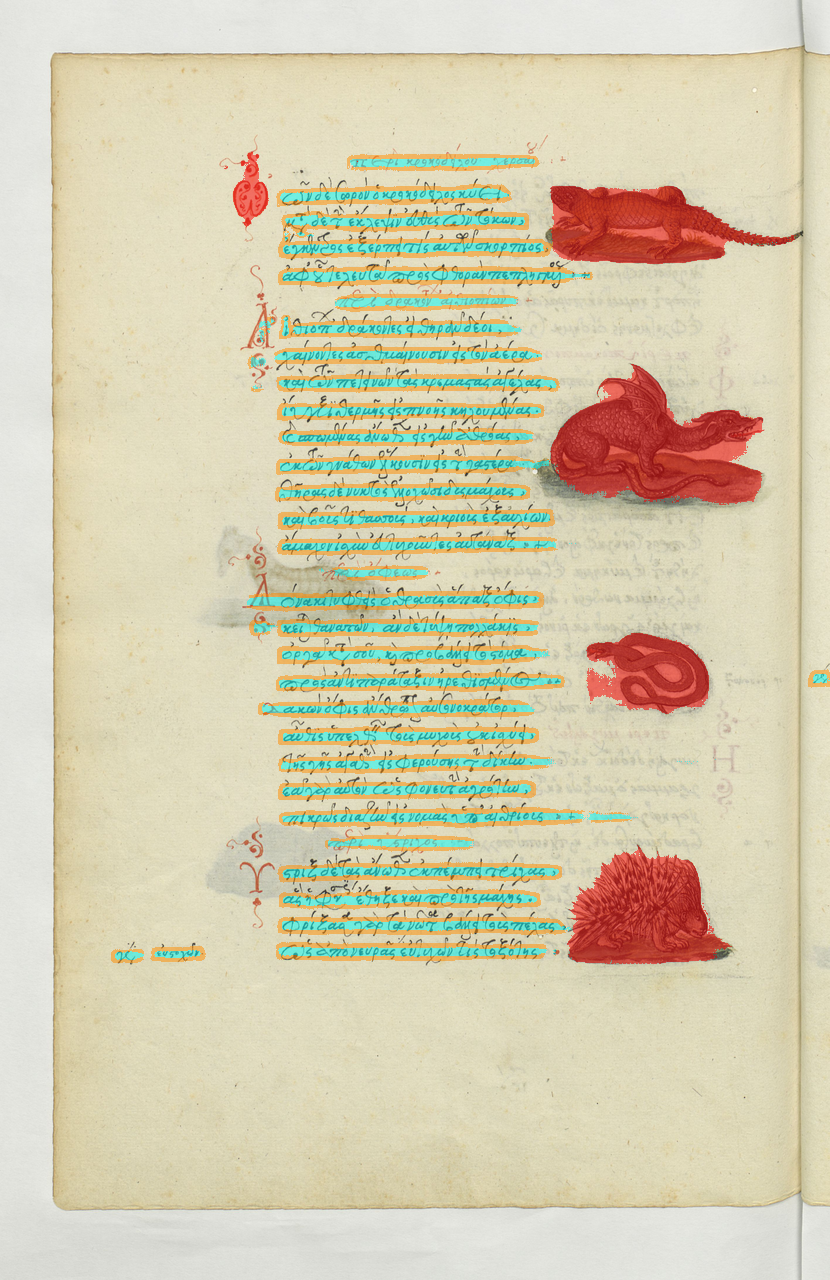

In [5]:
from utils.constant import LABEL_TO_COLOR_MAPPING
from utils.image import LabeledArray2Image

# compute prediction
pred = model(inp.reshape(1, *inp.shape))[0].max(0)[1].cpu().numpy()

# Retrieve good color mapping and transform to image
restricted_colors = [LABEL_TO_COLOR_MAPPING[l] for l in restricted_labels]
label_idx_color_mapping = {restricted_labels.index(l) + 1: c for l, c in zip(restricted_labels, restricted_colors)}
pred_img = LabeledArray2Image.convert(pred, label_idx_color_mapping)

# Blend predictions with original image
mask = Image.fromarray((np.array(pred_img) == (0, 0, 0)).all(axis=-1).astype(np.uint8) * 127 + 128)
blend_img = Image.composite(img, pred_img, mask)
blend_img